# Brackets Data Exploration
The goal of this notebook is to identify key points in the current Brackets analytics logs to track an identify usage patterns


In [1]:
import json
import datetime
from collections import Counter
import requests
import os
import matplotlib.pyplot as plt
import numpy as np

## Loading the Data 
There are 15,311 log files that we need to analyze. We will check only the first 1,000 files.

In [2]:
%%capture
!gdown 1Gjldh5ThKTG89BwmLMbXgfcR2RWUHjwq
!unzip Copy\ of\ brackets.zip

In [3]:
len(os.listdir('./brackets'))

15311

In [4]:
path = './brackets/'
c_data = []
for filepath in os.listdir(path)[:1000]:
  with open(path+filepath) as f:
    data = json.load(f)
    c_data.extend(data['clientAnalytics'][:-1])

In [5]:
len(c_data)

524358

In [6]:
c_data[0].keys()

dict_keys(['schemaVersion', 'accountID', 'appName', 'uuid', 'sessionID', 'unixTimestampUTC', 'numEventsTotal', 'events', 'geolocation'])

There are 524,358 client records in the 1000 log files. Each client records contains a unique identifier (uuid) and their geolocation (geolocation), the time the log was recorded (unixTimestampUTC), the number of events that were recorded (numEventsTotal), and a list of the events that took place.

## Data samples

In [7]:
c_data[72]

{'schemaVersion': 1,
 'accountID': 'brackets',
 'appName': 'brackets-prod',
 'uuid': '857db5d5-0b8c-4ea5-8f93-38f1a46c0047',
 'sessionID': 'b66pdzbp6e',
 'unixTimestampUTC': 1658940286268,
 'numEventsTotal': 25,
 'events': {'usage': {'fileOpen': {'html': {'time': [0], 'valueCount': [1]}}},
  'core-analytics': {'client-lib': {'loadTime': {'time': [0],
     'valueCount': [{'1432': 1}]}}},
  'PLATFORM': {'os': {'mac': {'time': [0], 'valueCount': [1]}},
   'osLanguage': {'pl-PL': {'time': [0], 'valueCount': [1]}},
   'bracketsLanguage': {'pl-PL': {'time': [0], 'valueCount': [1]}},
   'bracketsVersion': {'2.1.2-17937': {'time': [0], 'valueCount': [1]}},
   'AppStartupTime': {'AppStartupTime': {'time': [0], 'valueCount': [1]}},
   'ModuleDepsResolved': {'ModuleDepsResolved': {'time': [0],
     'valueCount': [1789]}}},
  'PROJECT': {'numFiles': {'numFiles': {'time': [0], 'valueCount': [3]}},
   'cacheSize': {'cacheSize': {'time': [0], 'valueCount': [41344]}},
   'numProjectsOpened': {'numProj

This is a user from Poland. Here we see some things about his platform (mac), some of his usage (fileOpen), and other events.

In [8]:
c_data[528]

{'schemaVersion': 1,
 'accountID': 'brackets',
 'appName': 'brackets-prod',
 'uuid': '6d0d5c60-10ab-4412-b386-90bf2ff1bdb9',
 'sessionID': '5ldltnrpcd',
 'unixTimestampUTC': 1665801863814,
 'numEventsTotal': 2,
 'events': {'usage': {'fileSave': {'html': {'time': [3], 'valueCount': [1]}},
   'livePreview': {'open': {'time': [6], 'valueCount': [1]}}}},
 'geolocation': {'continent': 'Asia', 'country': 'Japan', 'city': 'Chiyoda'}}

This is a user from Japan. Here only his usage events, (fileSave and livePreview), were recorded.

## Count analysis
Now we want to find what and how many types of events there are and hone in to some of the more interesting ones. We preidentified 'usage' to be an event of interest

In [9]:
event_types = Counter()
usage_types = Counter()
os_types = Counter()
uuids = Counter()

for client in c_data:
    events = client.get('events', {'None':None})
    event_types.update(events.keys())
    uuids.update([client['uuid']])


    if 'usage' in events.keys():
        usage_types.update(events['usage'].keys())
    if 'PLATFORM' in events.keys():
        os_types.update(events['PLATFORM']['os'].keys())

### Users

In [10]:
uuids.most_common(10)

[('ec0cf5d0-0a90-4ec5-a3f8-37c658c245f9', 351),
 ('329ec3bc-e27f-437a-8c88-be65a1be4b6d', 318),
 ('a39afb12-991a-4f45-a882-58d531351ddd', 292),
 ('e2d0feb6-dca1-4705-854c-5f165484b58b', 291),
 ('03fe9fd3-6b68-4e26-8127-54f417f94b59', 274),
 ('dc8d5e83-6a7d-47a3-8450-2035fd4807fb', 244),
 ('408bca79-9a4f-4976-9785-c4f621e9ee72', 218),
 ('d5b91bc6-a064-4df8-b797-adbd2c237a4f', 209),
 ('f1d96cd3-dab9-40b1-9582-d228624fad40', 204),
 ('28a7acb1-8211-4035-8383-11da918513c1', 202)]

In [11]:
len(uuids)

107509

From the 524,358 client records, we only saw 107,509 unique uuids. This means most records are from repeat users.

### Events

In [12]:
event_types

Counter({'PLATFORM': 81573,
         'PROJECT': 81568,
         'searchDetails': 81568,
         'THEMES': 81568,
         'EXTENSIONS': 81568,
         'FILE_STATS': 57549,
         'usage': 403834,
         'core-analytics': 143606,
         'installedExtensions': 27270,
         'navbar': 8454})

In [13]:
usage_types

Counter({'fileOpen': 205194,
         'fileSave': 117458,
         'fileClose': 54642,
         'languageChange': 4200,
         'livePreview': 42951,
         'quickEdit': 1991,
         'projectSettings': 864,
         'languageServerProtocol': 1645,
         'externalEditors': 6971,
         'multiCursor': 9872,
         'jsRefactor': 137,
         'quickDoc': 550})

### Platform

In [14]:
os_types

Counter({'mac': 28956, 'win': 52617})

In [15]:
sum(os_types.values())

81573

Against 107,509 uuids, and assuming that the 81,573 are one-to-one for a uuid, then some uuids are missing a platform. 

## Timestamps

In [16]:
timestamps = [c['unixTimestampUTC'] for c in c_data]

In [17]:
datetime.datetime.fromtimestamp(min(timestamps)/1000)

datetime.datetime(1970, 1, 13, 12, 38, 28, 848000)

In [18]:
datetime.datetime.fromtimestamp(max(timestamps)/1000)

datetime.datetime(2022, 11, 21, 11, 43, 26, 296000)

A timestamp of less than year 2014 or 2021 is erroenous, since Brackets was first released in 2014 and became a community project in 2021. We will have to clean records.

In [19]:
err = [t for t in timestamps if t<1635984000000] # Nov 4, 2021 in ms since epoch
err

[1082308848,
 1230760983934,
 1230760923920,
 1273032174652,
 1273036194655,
 1273032354655,
 1262315084839]

In [20]:
timestamps = [datetime.datetime.fromtimestamp(t/1000) for t in timestamps if t not in err]

(array([738156., 738187., 738215., 738246., 738276., 738307., 738337.,
        738368., 738399., 738429., 738460., 738490.]),
 <a list of 12 Text major ticklabel objects>)

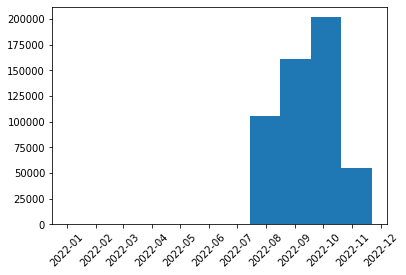

In [21]:
plt.hist(np.asarray(timestamps))
plt.xticks(rotation=45)